In [19]:
import tensorflow as tf
import pandas
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
 

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Segmentation Task
For each test image pixel, predict the class of the object containing that pixel or "background" if the pixel doesnot belong to one of the 20 classes.
__output__ Should be an indexed image with each pixel index indicating the number of the inferred class (1-20) or 0, indicating background

### Organize Dataset

#### Inputs
The input data for semantic segmenation are regular images. In our case Jpeg files from Pascal VOC 2009 dataset. 

#### Labels
The labels can come in different forms. 
![](semantic_labels_type.png)

* _A_ Greyscale images semantic masks.  where pixel intensity represents the class. Easy to work with, little to no preprocessing requires
* _B_ RGB images semantic masks. The different classes have each a unique RGB encoding. Convenient for human consumption. Requires pre processing to map RGB values to class labels or one hot encodings. 
* _C_ One hote encoding. Each pixel is encoded as a one hot vector, with a value of 1 for the class it represent, 0 elsewhere. The best and most readily compatible way to use semantic labels

#### Output of the Segmentation Model

A Tensor of shape [[n_samples, height, width, n_classes]]. _height_ and _width_ are the same of the input images. _nclasses_ contains the predicted probability distributions of each class for any pixel following the one-hot input vector encodings. 

![](images_notebook/segmentation_output.png)


In [22]:
# 

voc_dir = '/home/nico/CV3/VOCdevkit/VOC2009' #modify path with your own path where you stored the dataset downloaded from http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html 

#for convenience, we set a square 256x256 image size as the input size of the network. Images in the dataset are usually max 500px wide 
im_rows = 256
im_cols = 256

def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    
    features, masks = [], []
    n_classes = 21

    for i, fname in enumerate(images):
        
        current_img = cv2.cvtColor(cv2.imread(os.path.join(voc_dir, 'JPEGImages', '%s.jpg' % fname)), cv2.COLOR_BGR2RGB)
        #add the following line to resize images to fit network
        current_img = cv2.resize(current_img, dsize=(im_rows,im_cols))
        features.append(current_img)

        current_mask = cv2.cvtColor(cv2.imread(os.path.join(voc_dir, 'SegmentationClass', '%s.png' % fname)), cv2.COLOR_BGR2RGB)
        #add the following line to resize images masks to fit network
        current_mask = cv2.resize(current_mask, dsize=(im_rows,im_cols))
        masks.append(current_mask)

    features = np.array(features)
    masks = np.array(masks)

    return features, masks

#populate two arrays 
train_features, train_masks = read_voc_images(voc_dir, True)
val_features, val_masks = read_voc_images(voc_dir, False)

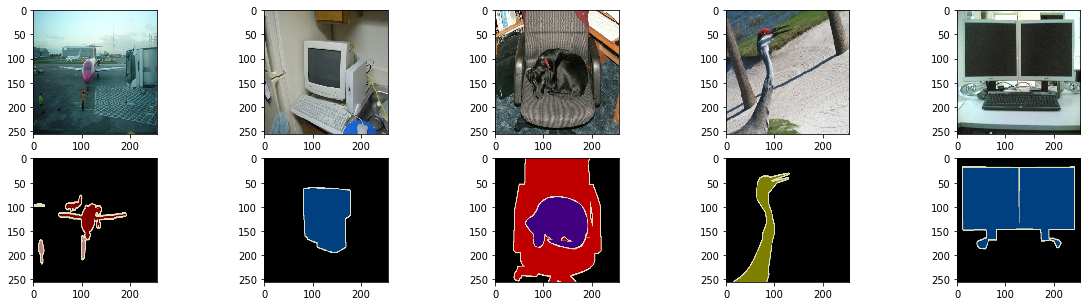

In [23]:
#create a figure to show some images from the TRAINING set and their respective segmentation masks
fig = plt.figure(figsize=(20,5))
columns = 5
rows = 2
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    if i < columns:
        plt.imshow(train_features[i])
    else:
        plt.imshow(train_masks[i-columns])
plt.show()


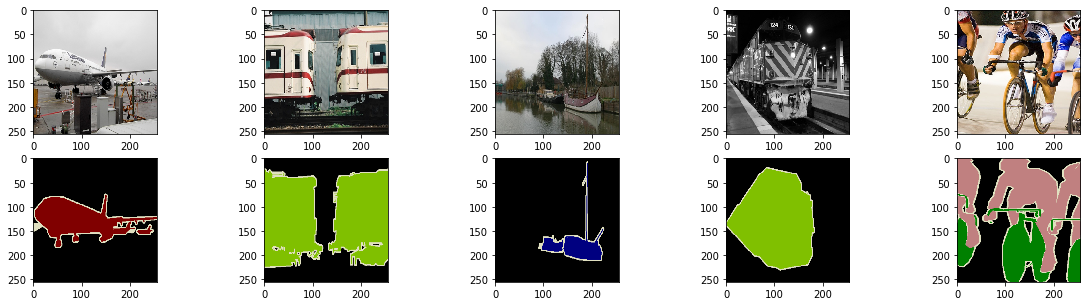

In [24]:
#create a figure to show some images from the VALIDATION set and their respective segmentation masks

fig = plt.figure(figsize=(20,5))
columns = 5
rows = 2
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    if i < columns:
        plt.imshow(val_features[i])
    else:
        plt.imshow(val_masks[i-columns])
plt.show()


### One Hot encoding 

In this section we

In [25]:
# array with the class names of the 20 categories
seg_classes = np.array(["background","aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow","diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa","train","tvmonitor"])

seg_classes_n = np.arange(21)
#list with the unique color maps of the segmentation masks. This comes out of nowehre though. It is just given here: https://d2l.ai/chapter_computer-vision/semantic-segmentation-and-dataset.html 

seg_colormap = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

In [26]:
color_dict = dict(zip(seg_classes, seg_colormap))
colormap_dict = dict(zip(seg_classes_n, seg_colormap))
print(color_dict)
print(colormap_dict)

{'background': [0, 0, 0], 'aeroplane': [128, 0, 0], 'bicycle': [0, 128, 0], 'bird': [128, 128, 0], 'boat': [0, 0, 128], 'bottle': [128, 0, 128], 'bus': [0, 128, 128], 'car': [128, 128, 128], 'cat': [64, 0, 0], 'chair': [192, 0, 0], 'cow': [64, 128, 0], 'diningtable': [192, 128, 0], 'dog': [64, 0, 128], 'horse': [192, 0, 128], 'motorbike': [64, 128, 128], 'person': [192, 128, 128], 'pottedplant': [0, 64, 0], 'sheep': [128, 64, 0], 'sofa': [0, 192, 0], 'train': [128, 192, 0], 'tvmonitor': [0, 64, 128]}
{0: [0, 0, 0], 1: [128, 0, 0], 2: [0, 128, 0], 3: [128, 128, 0], 4: [0, 0, 128], 5: [128, 0, 128], 6: [0, 128, 128], 7: [128, 128, 128], 8: [64, 0, 0], 9: [192, 0, 0], 10: [64, 128, 0], 11: [192, 128, 0], 12: [64, 0, 128], 13: [192, 0, 128], 14: [64, 128, 128], 15: [192, 128, 128], 16: [0, 64, 0], 17: [128, 64, 0], 18: [0, 192, 0], 19: [128, 192, 0], 20: [0, 64, 128]}


In [27]:

def onehot_encoding (mask, clr_dict):
    """ function that maps a rgb semantic color mask for the full image into a one-hot encoding

        mask is an rgb array representing a .png image of a semantic mask // mask = numpy.array(image height, image width, 3)
        clr_dict is a dictionary containing the key value pairs of a semantic mask [integer 0 <key < #of classes] and its RGB encoding [an array (1,3)]""" 
    
    #added also this line to treat the boundaries of the semantic objects masks as background. remove if not necessary later for experimentation
    mask[np.all(mask == (255, 255, 255), axis=-1)] = (0,0,0)
    # -----------------------------

    h = mask.shape[0]
    w = mask.shape[1]
    c = len(clr_dict)
    onehot = np.zeros((h, w, c), dtype=np.int8)

    for i, clrs in enumerate(clr_dict):
        bolmap = np.all(mask.reshape((-1,3)) == clr_dict[i], axis=1)
        onehot[:,:,i] = bolmap.reshape((h,w))

    return onehot 


def onehot_to_RGB (onehot_encoded_mask, clr_dict):
    """ function that maps a one-hot encoded color mask into an rgb image following a dictionary

        onehot_encoded_mask is a numpy array representing a one hot encoded image of a semantic mask // onehot-encoded_mask  = numpy.array(image height, image width, n_classes)
        clr_dict is a dictionary containing the key value pairs of a semantic mask [integer 0 < key < #of classes] and its RGB encoding [an array of shape (1,3)]""" 

    h = onehot_encoded_mask.shape[0]
    w = onehot_encoded_mask.shape[1]
    c = 3
    rgb_output = np.zeros((h,w,c), dtype=np.int8) 

    single_layer = np.argmax(onehot_encoded_mask, axis =-1)
    for k in clr_dict.keys():
        rgb_output[single_layer == k] = clr_dict[k]

    return np.uint8(rgb_output)



In [28]:
#perform one-hot encoding on all the .png mask images in the training set. 
onehot_train = []

for i in range(len(train_masks)):
    onehot_train.append(onehot_encoding(train_masks[i], colormap_dict))

#perform one-hot encoding on all the .png mask images in the validation set
onehot_val = []

for v in range(len(val_masks)):
    onehot_val.append(onehot_encoding(val_masks[v], colormap_dict)) 


onehot_train = np.array(onehot_train)
onehot_val = np.array(onehot_val)


In [29]:
#sanity check on dimensions 
print('train feat',train_features.shape)  
print('train masks onehot', onehot_train.shape)
print('val feat', val_features.shape)
print('val masks onehot', onehot_val.shape)

train feat (749, 256, 256, 3)
train masks onehot (749, 256, 256, 21)
val feat (750, 256, 256, 3)
val masks onehot (750, 256, 256, 21)


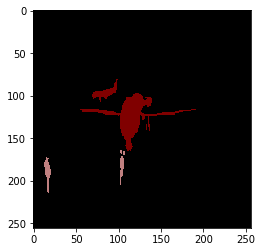

In [30]:
example = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(voc_dir, 'SegmentationClass', '2007_000032.png')), cv2.COLOR_BGR2RGB), dsize=(im_rows,im_cols))

tester = onehot_encoding(example, colormap_dict)
#print(tester)

detester = onehot_to_RGB(tester, colormap_dict)

plt.imshow(detester)

### Crafting the Semantic Segmentation model

In this section we build the model 

In [31]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU

batch_size     = 32
num_epochs     = 10
num_classes    = 21

#Build U-Net model
inputs = Input(shape=(im_rows, im_cols, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(21, (1, 1), activation= 'softmax') (c9)

print(outputs.shape)

(None, 256, 256, 21)


In [32]:
seg_unet = Model(inputs=[inputs], outputs=[outputs])
seg_unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=21)])
seg_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 32) 128         conv2d_19[0][0]                  
____________________________________________________________________________________________

In [33]:
#fit model

earlystopper = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
results = seg_unet.fit(train_features, onehot_train, batch_size=32, epochs=10, validation_data=(val_features, onehot_val))

Train on 749 samples, validate on 750 samples
Epoch 1/10
 32/749 [>.............................] - ETA: 42s

UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/conv2d_19/Conv2D (defined at <ipython-input-33-47ec51f57d58>:5) ]]
	 [[metrics/mean_io_u_1/confusion_matrix/stack_1/_82]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/conv2d_19/Conv2D (defined at <ipython-input-33-47ec51f57d58>:5) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_16059]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/conv2d_19/Conv2D:
 model_1/lambda_1/truediv (defined at <ipython-input-31-cd870bd2f8b6>:16)

Input Source operations connected to node model_1/conv2d_19/Conv2D:
 model_1/lambda_1/truediv (defined at <ipython-input-31-cd870bd2f8b6>:16)

Function call stack:
distributed_function -> distributed_function


In [34]:
print(results)

NameError: name 'results' is not defined